<a href="https://colab.research.google.com/github/lokeshGiri3003/TriWizardathon/blob/main/src_code(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MODEL TRAINING CODE**

run the code to get the model

---




=== Train Set Evaluation ===
              precision    recall  f1-score   support

           0     0.9966    0.9975    0.9970     22398
           1     0.9977    0.9969    0.9973     24518

    accuracy                         0.9972     46916
   macro avg     0.9971    0.9972    0.9972     46916
weighted avg     0.9972    0.9972    0.9972     46916

ROC-AUC: 0.9999
Accuracy: 0.9972
Precision: 0.9977
Recall: 0.9969
F1 Score: 0.9973

Confusion Matrix (Train):
 [[22341    57]
 [   76 24442]]


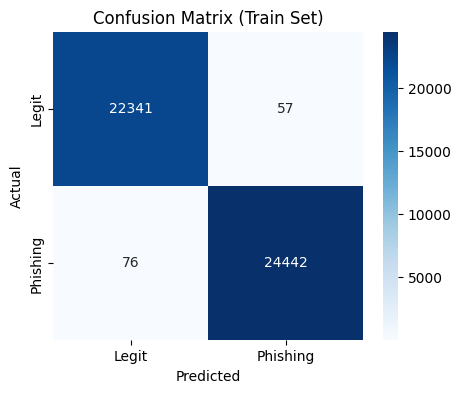


=== Test Set Evaluation ===
              precision    recall  f1-score   support

           0     0.9595    0.9470    0.9532      5600
           1     0.9521    0.9635    0.9577      6129

    accuracy                         0.9556     11729
   macro avg     0.9558    0.9552    0.9555     11729
weighted avg     0.9556    0.9556    0.9556     11729

ROC-AUC: 0.9908
Accuracy: 0.9556
Precision: 0.9521
Recall: 0.9635
F1 Score: 0.9577

Confusion Matrix (Test):
 [[5303  297]
 [ 224 5905]]


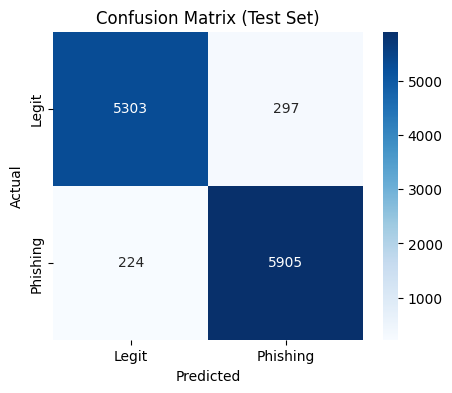

✅ Model and feature order saved.


In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, accuracy_score,
    precision_score, recall_score, f1_score, confusion_matrix
)
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# === Practical Network + Lexical Features ===
PRACTICAL_FEATURES = [

    "asn_ip", "domain_spf", "ttl_hostname", "tls_ssl_certificate",
    "qty_ip_resolved", "qty_nameservers", "qty_mx_servers",
    "time_domain_activation", "time_domain_expiration",
    "qty_redirects", "time_response", "url_google_index", "domain_google_index",
    "length_url", "directory_length", "domain_length", "file_length",
    "qty_dot_url", "qty_dot_domain", "qty_dot_directory",
    "qty_slash_url", "qty_slash_directory", "qty_hyphen_domain",
    "qty_hyphen_file", "qty_at_url", "qty_at_directory",
    "qty_questionmark_file", "email_in_url", "url_shortened",
    "qty_percent_directory"

]

def evaluate_model(model, X, y, dataset_name="Test"):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    print(f"\n=== {dataset_name} Set Evaluation ===")
    print(classification_report(y, y_pred, digits=4))
    print(f"ROC-AUC: {roc_auc_score(y, y_prob):.4f}")
    print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred):.4f}")
    print(f"Recall: {recall_score(y, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y, y_pred):.4f}")

    cm = confusion_matrix(y, y_pred)
    print(f"\nConfusion Matrix ({dataset_name}):\n", cm)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Legit", "Phishing"],
                yticklabels=["Legit", "Phishing"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({dataset_name} Set)")
    plt.show()

def train_practical_features(data_path="dataset_small.csv"):
    df = pd.read_csv(data_path)

    # 🔀 Feature and Label
    X = df[PRACTICAL_FEATURES]
    y = df["phishing"]

    # 🔀 Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 🌲 Train
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # 📊 Evaluate
    evaluate_model(model, X_train, y_train, "Train")
    evaluate_model(model, X_test, y_test, "Test")

    # 💾 Save model
    joblib.dump(model, "random_forest_practical.pkl")
    with open("RF_feature_order.txt", "w") as f:
        for feat in PRACTICAL_FEATURES:
            f.write(feat + "\n")
    print("✅ Model and feature order saved.")

# ✅ Run
train_practical_features("/content/drive/MyDrive/PHISHING URL DETECTION /dataset_small.csv")


**ML MODEL CODE**

In [92]:
import re
import socket
import ssl
import time
import dns.resolver
import requests
import joblib
import pandas as pd
from urllib.parse import urlparse
import numpy as np
import datetime

# --- Configuration ---
# IMPORTANT: Replace "YOUR_WHOIS_API_KEY_HERE" with your actual API key from WhoisXML API
# Example: WHOIS_API_KEY = "at_YOUR_ACTUAL_API_KEY_HERE"
WHOIS_API_KEY = "at_RWKoqIdZQsZBg45pwU3gvuIQf0mV2" # <<< REPLACE THIS WITH YOUR OWN VALID API KEY
# You might want to store this in an environment variable in production

# === Load feature order ===
def load_feature_order(path="XG_feature_order.txt"):
    try:
        with open(path) as f:
            return [line.strip() for line in f if line.strip()]
    except Exception as e:
        print(f"Error loading model feature order from {path}: {e}")
        return []

# === Network Utility Functions ===

def get_fast_domain_info(domain):
    """ASN lookup using ipinfo.io"""
    try:
        resp = requests.get(f"https://ipinfo.io/{domain}/json", timeout=3)
        if resp.status_code == 200:
            data = resp.json()
            asn_val = data.get("asn", "")
            asn_num = int(asn_val.replace("AS", "")) if isinstance(asn_val, str) and asn_val.startswith("AS") else 0
            org = data.get("org", "Unknown")
            country = data.get("country", "NA")
            return asn_num, org, country
    except requests.exceptions.RequestException as e:
        # print(f"Error getting fast domain info for {domain}: {e}") # Uncomment for debugging
        pass
    return 0, "Unknown", "NA"

def get_ttl_hostname(domain):
    try:
        answers = dns.resolver.resolve(domain, 'A')
        return answers.rrset.ttl if answers.rrset else 0
    except (dns.resolver.NXDOMAIN, dns.resolver.NoAnswer, dns.resolver.NoNameservers, dns.exception.Timeout) as e:
        # print(f"DNS resolution error for TTL of {domain}: {e}") # Uncomment for debugging
        return 0
    except Exception as e:
        # print(f"Generic error getting TTL for {domain}: {e}") # Uncomment for debugging
        return 0

def has_valid_ssl(domain):
    try:
        ctx = ssl.create_default_context()
        with ctx.wrap_socket(socket.socket(), server_hostname=domain) as s:
            s.settimeout(5)
            s.connect((domain, 443))
            cert = s.getpeercert()
            return 1 if cert else 0
    except (socket.timeout, ConnectionRefusedError, ssl.SSLError, socket.gaierror) as e:
        # print(f"SSL error for {domain}: {e}") # Uncomment for debugging
        return 0
    except Exception as e:
        # print(f"Generic SSL check error for {domain}: {e}") # Uncomment for debugging
        return 0

def has_spf_record(domain):
    try:
        answers = dns.resolver.resolve(domain, 'TXT')
        for txt_record in answers:
            if "v=spf1" in str(txt_record):
                return 1
        return 0
    except (dns.resolver.NXDOMAIN, dns.resolver.NoAnswer, dns.resolver.NoNameservers, dns.exception.Timeout) as e:
        # print(f"DNS resolution error for SPF of {domain}: {e}") # Uncomment for debugging
        return 0
    except Exception as e:
        # print(f"Generic error checking SPF record for {domain}: {e}") # Uncomment for debugging
        return 0

def get_redirects_and_response_time(url):
    try:
        start = time.time()
        resp = requests.get(url, timeout=5, allow_redirects=True)
        elapsed = time.time() - start
        return len(resp.history), round(elapsed, 2), len(resp.content)
    except requests.exceptions.RequestException as e:
        # print(f"Request error for {url}: {e}") # Uncomment for debugging
        return 0, 5.0, 0 # Default values in case of request failure

def get_domain_age_via_api(domain, api_key):
    """
    Fetches domain creation date using WhoisXML API.
    """
    if not api_key or api_key == "YOUR_WHOIS_API_KEY_HERE":
        print("⚠️ WHOIS API key not provided or is default. Domain age will be 0.")
        return 0

    # Clean the domain to only be the hostname (e.g., remove 'http://' or paths)
    parsed_domain = urlparse(domain)
    clean_domain = parsed_domain.netloc if parsed_domain.netloc else parsed_domain.path
    if '/' in clean_domain:
        clean_domain = clean_domain.split('/')[0]
    clean_domain = clean_domain.split('://')[-1] # Remove protocol if it was direct input like 'http://example.com'

    # Further clean domain from 'www.' or trailing slashes if present
    clean_domain = clean_domain.replace('www.', '').strip('/')

    if not clean_domain: # If still empty after stripping www, return 0
        print(f"Could not extract a valid domain from '{domain}'. Returning 0 for age.")
        return 0

    try:
        api_endpoint = "https://www.whoisxmlapi.com/whoisserver/WhoisService"
        params = {
            "apiKey": api_key,
            "domainName": clean_domain,
            "outputFormat": "JSON"
        }

        resp = requests.get(api_endpoint, params=params, timeout=10)
        resp.raise_for_status() # Raises HTTPError for bad responses (4xx or 5xx)
        data = resp.json()

        creation_date_str = data.get("WhoisRecord", {}).get("createdDate")

        if creation_date_str:
            try:
                creation_date = pd.to_datetime(creation_date_str, errors='coerce')

                if pd.isna(creation_date):
                    raise ValueError(f"Could not parse date: {creation_date_str}")

                # Ensure both current time and creation date are timezone-aware and in UTC
                now_utc = pd.Timestamp.now(tz='UTC')

                # If creation_date is naive, localize it to UTC. If already aware, convert to UTC.
                if creation_date.tz is None:
                    creation_date = creation_date.tz_localize('UTC')
                else:
                    creation_date = creation_date.tz_convert('UTC')

                age_days = (now_utc - creation_date).days
                return age_days
            except ValueError as ve:
                print(f"Error parsing or localizing date '{creation_date_str}' for {clean_domain}: {ve}. Returning 0.")
                return 0
    except requests.exceptions.RequestException as e:
        print(f"WHOIS API request failed for {clean_domain}. Check API key and network. Error: {e}")
    except Exception as e:
        print(f"Generic error in WHOIS API lookup for {clean_domain}: {e}")
    return 0

def get_domain_age(domain):
    """
    Wrapper function to call the API-based domain age retrieval.
    """
    return get_domain_age_via_api(domain, WHOIS_API_KEY)

def resolve_nameservers(domain):
    try:
        ns = dns.resolver.resolve(domain, 'NS')
        return len(ns)
    except (dns.resolver.NXDOMAIN, dns.resolver.NoAnswer, dns.resolver.NoNameservers, dns.exception.Timeout) as e:
        # print(f"DNS resolution error for NS of {domain}: {e}") # Uncomment for debugging
        return 0
    except Exception as e:
        # print(f"Generic error resolving NS records for {domain}: {e}") # Uncomment for debugging
        return 0

def resolve_mx(domain):
    try:
        mx = dns.resolver.resolve(domain, 'MX')
        return len(mx)
    except (dns.resolver.NXDOMAIN, dns.resolver.NoAnswer, dns.resolver.NoNameservers, dns.exception.Timeout) as e:
        # print(f"DNS resolution error for MX of {domain}: {e}") # Uncomment for debugging
        return 0
    except Exception as e:
        # print(f"Generic error resolving MX records for {domain}: {e}") # Uncomment for debugging
        return 0

# === Feature Extraction ===
def extract_selected_features(url):
    parsed = urlparse(url)
    domain = parsed.netloc if parsed.netloc else parsed.path
    # Clean domain in case it contains path elements
    if '/' in domain:
        domain = domain.split('/')[0]
    # Remove protocol if it's still there (e.g., in case of a direct path input like 'example.com/path')
    domain = domain.split('://')[-1]
    # Further clean domain from 'www.' or trailing slashes if present
    domain = domain.replace('www.', '').strip('/')

    path = parsed.path
    full_url = url

    feats = {}

    # Lexical
    feats["length_url"] = len(full_url)
    feats["directory_length"] = len(path)
    feats["domain_length"] = len(domain)
    feats["file_length"] = len(path.split("/")[-1])
    feats["qty_dot_url"] = full_url.count(".")
    feats["qty_dot_domain"] = domain.count(".")
    feats["qty_dot_directory"] = path.count(".")
    feats["qty_slash_url"] = full_url.count("/")
    feats["qty_slash_directory"] = path.count("/")
    feats["qty_hyphen_domain"] = domain.count("-")
    feats["qty_hyphen_file"] = path.split("/")[-1].count("-")
    feats["qty_at_url"] = full_url.count("@")
    feats["qty_at_directory"] = path.count("@")
    feats["qty_questionmark_file"] = path.split("/")[-1].count("?")
    feats["email_in_url"] = 1 if "mailto:" in full_url.lower() else 0
    feats["url_shortened"] = 1 if re.search(r"(bit\.ly|tinyurl\.com|goo\.gl|t\.co|ow\.ly|buff\.ly|rebrand\.ly|is\.gd|s\.id|cutt\.ly|cli\.gs|vc\.ru|adf\.ly|rb\.gy|v\.gd)", full_url) else 0
    feats["qty_percent_directory"] = path.count("%")

    # Network
    # Pass the cleaned domain to network functions
    asn_num, asn_org, asn_country = get_fast_domain_info(domain)
    feats["asn_ip"] = asn_num
    feats["domain_spf"] = has_spf_record(domain)
    feats["ttl_hostname"] = get_ttl_hostname(domain)
    feats["tls_ssl_certificate"] = has_valid_ssl(domain)

    try:
        socket.gethostbyname(domain)
        feats["qty_ip_resolved"] = 1
    except socket.gaierror:
        feats["qty_ip_resolved"] = 0

    feats["qty_nameservers"] = resolve_nameservers(domain)
    feats["qty_mx_servers"] = resolve_mx(domain)
    feats["time_domain_activation"] = get_domain_age(domain)
    # The actual expiration would come from WHOIS. Assuming a 1-year registration if unknown.
    feats["time_domain_expiration"] = feats["time_domain_activation"] + 365 # Placeholder
    redirects, resp_time, content_length = get_redirects_and_response_time(url)
    feats["qty_redirects"] = redirects
    feats["time_response"] = resp_time
    feats["content_length"] = content_length
    feats["url_google_index"] = 0 # This usually requires Google Search API or scraping, not directly covered
    feats["domain_google_index"] = 0 # Same as above

    return feats, {"asn_org": asn_org, "asn_country": asn_country}

# === Final Prediction ===
def predict_url_selected_features(url,
                                  model_path="/content/random_forest_practical.pkl",
                                  feature_order_path="/content/RF_feature_order.txt"):
    try:
        model = joblib.load(model_path)
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}. Please check the path.")
        return "Error", 0.0
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        return "Error", 0.0

    feature_order = load_feature_order(feature_order_path)
    if not feature_order:
        print("Error: Feature order not loaded. Cannot proceed with prediction.")
        return "Error", 0.0

    feats_dict, org_info = extract_selected_features(url)

    # Ensure all features in feature_order are present, fill with 0 if missing
    ordered_feats = [feats_dict.get(f, 0) for f in feature_order]

    X = pd.DataFrame([ordered_feats], columns=feature_order)

    # Check if the dataframe columns match the model's expected features
    # This is a robust check, especially important if the model was trained with specific feature names
    if hasattr(model, 'feature_names_in_') and not all(col in model.feature_names_in_ for col in X.columns):
        print("Warning: Feature mismatch between extracted features and model. This might lead to incorrect predictions.")
        # If columns don't match exactly, reindex X to match model's expected features
        X = X.reindex(columns=model.feature_names_in_, fill_value=0)

    base_prob = model.predict_proba(X)[0][1]

    # Apply a common threshold for phishing detection
    final_prob = min(max(base_prob, 0), 1.0) # Ensure probability is between 0 and 1
    phishing_threshold = 0.55 # Can be tuned
    pred = "Phishing 🚨" if final_prob > phishing_threshold else "Legitimate ✅"

    print("\n=== Prediction Result ===")
    print(f"URL: {url}")
    print(f"Base Model Probability (Phishing): {base_prob:.2f}")
    print(f"Final Phishing Probability: {final_prob:.2f}")
    print(f"Prediction: {pred}")
    print("\n--- Network Details ---")
    print(f"ASN Org: {org_info['asn_org']}")
    print(f"ASN Country: {org_info['asn_country']}")
    for k in ["asn_ip", "domain_spf", "ttl_hostname", "tls_ssl_certificate",
              "qty_ip_resolved", "qty_nameservers", "qty_mx_servers",
              "qty_redirects", "time_response", "content_length",
              "time_domain_activation", "time_domain_expiration"]:
        print(f"{k}: {feats_dict.get(k, 'N/A')}") # Use .get with default 'N/A' for robustness

    return pred, final_prob

# === Interactive ===
if __name__ == "__main__":
    # Example usage:
    # Make sure to replace "/content/random_forest_practical.pkl"
    # and "/content/RF_feature_order.txt" with actual paths if running locally.
    # If running in Colab, ensure these files are uploaded to /content/

    # Create dummy files for demonstration if they don't exist
    import os
    if not os.path.exists("/content/random_forest_practical.pkl"):
        print("Creating dummy model file for demonstration...")
        from sklearn.ensemble import RandomForestClassifier
        dummy_model = RandomForestClassifier(random_state=42)
        # Create a dummy feature order that roughly matches the features extracted
        dummy_feature_order = [
              "length_url", "directory_length", "domain_length", "file_length",
              "qty_dot_url", "qty_dot_domain", "qty_dot_directory", "qty_slash_url",
              "qty_slash_directory", "qty_hyphen_domain", "qty_hyphen_file",
              "qty_at_url", "qty_at_directory", "qty_questionmark_file",
              "email_in_url", "url_shortened", "qty_percent_directory",
              "asn_ip", "domain_spf", "ttl_hostname", "tls_ssl_certificate",
              "qty_ip_resolved", "qty_nameservers", "qty_mx_servers",
              "time_domain_activation", "time_domain_expiration",
              "qty_redirects", "time_response", "content_length",
              "url_google_index", "domain_google_index"
          ]
        # Dummy fit required for joblib to save properly
        dummy_X = pd.DataFrame(np.random.rand(10, len(dummy_feature_order)), columns=dummy_feature_order)
        dummy_y = np.random.randint(0, 2, 10)
        dummy_model.fit(dummy_X, dummy_y)

        joblib.dump(dummy_model, "/content/random_forest_practical.pkl")
        with open("/content/RF_feature_order.txt", "w") as f:
            for feature in dummy_feature_order:
                f.write(feature + "\n")
        print("Dummy model and feature order created.")

    print("Please enter ONLY the URL when prompted. For example: https://www.example.com")
    url_input = input("\n🔗 Enter a URL: ").strip()
    predict_url_selected_features(
        url_input,
        model_path="/content/random_forest_practical.pkl",
        feature_order_path="/content/RF_feature_order.txt"
    )

Please enter ONLY the URL when prompted. For example: https://www.example.com

🔗 Enter a URL: https://www.example.com

=== Prediction Result ===
URL: https://www.example.com
Base Model Probability (Phishing): 0.15
Final Phishing Probability: 0.15
Prediction: Legitimate ✅

--- Network Details ---
ASN Org: Unknown
ASN Country: NA
asn_ip: 0
domain_spf: 1
ttl_hostname: 300
tls_ssl_certificate: 1
qty_ip_resolved: 1
qty_nameservers: 2
qty_mx_servers: 1
qty_redirects: 0
time_response: 0.07
content_length: 1256
time_domain_activation: 12260
time_domain_expiration: 12625


**OVERALL PERDICATION CODE**

In [98]:
import re
import socket
import ssl
import time
import dns.resolver
import requests
import joblib
import pandas as pd
import numpy as np
import warnings
import sqlite3
import threading
import os
from urllib.parse import urlparse
import datetime
import logging

try:
    import tldextract
except ImportError:
    print("tldextract not found, installing...")
    os.system("pip install -q tldextract")
    import tldextract

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from google.colab import drive


warnings.filterwarnings("ignore", category=FutureWarning)


logging.basicConfig(filename='phishing_detection.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Database file path
DB_NAME = "/content/drive/MyDrive/PHISHING URL DETECTION /phishing_urls.db"

# VirusTotal API Key
VIRUSTOTAL_API_KEY = "e6587a6116bb57241a5b3be85ee7c190d54ff943bace8586809a543cb8c45cd6"

# IMPORTANT: Replace "YOUR_WHOIS_API_KEY_HERE" with your actual API key from WhoisXML API
WHOIS_API_KEY = "at_RWKoqIdQsdZBg45pwU3gvuIQf0mV2"


thread_local = threading.local()

# Feature list based ON YOUR TRAINING DATA - Adjusted for 31 features (added 'content_length', adjusted 'time_domain_expiration')
expected_features_for_training = [
    "length_url", "directory_length", "domain_length", "file_length",
    "qty_dot_url", "qty_dot_domain", "qty_dot_directory", "qty_slash_url",
    "qty_slash_directory", "qty_hyphen_domain", "qty_hyphen_file",
    "qty_at_url", "qty_at_directory", "qty_questionmark_file",
    "email_in_url", "url_shortened", "qty_percent_directory",
    "asn_ip", "domain_spf", "ttl_hostname", "tls_ssl_certificate",
    "qty_ip_resolved", "qty_nameservers", "qty_mx_servers",
    "time_domain_activation", "time_domain_expiration",
    "qty_redirects", "time_response",
    "url_google_index", "domain_google_index"
]

# --- Database Utility Functions ---
def get_db_connection():
    """Establishes and returns a thread-local SQLite database connection."""
    if not hasattr(thread_local, "conn"):
        try:
            thread_local.conn = sqlite3.connect(DB_NAME, timeout=10)
            thread_local.conn.isolation_level = None
            logging.info("Database connection established.")
        except sqlite3.Error as e:
            logging.error(f"Failed to connect to database: {e}")
            raise
    return thread_local.conn

def execute_with_retry(query, params=(), retries=5, delay=1):
    """Executes a database query with retry logic for operational errors."""
    for i in range(retries):
        try:
            conn = get_db_connection()
            cursor = conn.cursor()
            cursor.execute(query, params)
            logging.debug(f"DB query executed: {query} with params {params}")
            return True
        except sqlite3.OperationalError as e:
            logging.warning(f"Database locked, retrying ({i+1}/{retries}): {e}")
            time.sleep(delay * (2 ** i)) # Exponential backoff
        except Exception as e:
            logging.error(f"Error executing DB query '{query}' with params {params}: {e}")
            return False
    logging.error(f"Failed to execute DB query after {retries} retries: {query}")
    return False

def check_url_in_db(url):
    """Checks if a URL exists in the whitelist or blacklist database."""
    conn = get_db_connection()
    cursor = conn.cursor()

    cursor.execute("SELECT url FROM whitelist WHERE url = ?", (url,))
    if cursor.fetchone():
        logging.info(f"URL: {url} found in whitelist.")
        return "safe"

    cursor.execute("SELECT url FROM blacklist WHERE url = ?", (url,))
    if cursor.fetchone():
        logging.info(f"URL: {url} found in blacklist.")
        return "phishing"

    return "unknown"

# --- VirusTotal Functions ---
def test_virustotal_api():
    """Tests if the VirusTotal API is working by checking a known safe URL."""
    test_url = "https://www.google.com"
    if not VIRUSTOTAL_API_KEY or VIRUSTOTAL_API_KEY == "YOUR_VIRUSTOTAL_API_KEY_HERE":
        logging.warning("VIRUSTOTAL_API_KEY not set or is default. Skipping VirusTotal API test.")
        print("VIRUSTOTAL_API_KEY not set. Skipping VirusTotal API test.")
        return False

    try:
        headers = {"x-apikey": VIRUSTOTAL_API_KEY}
        response = requests.post("https://www.virustotal.com/api/v3/urls", headers=headers, data={"url": test_url}, timeout=10)
        response.raise_for_status()

        analysis_id = response.json()["data"]["id"]

        for _ in range(5): # Poll for results a few times
            time.sleep(2) # Wait before polling
            result_response = requests.get(f"https://www.virustotal.com/api/v3/analyses/{analysis_id}", headers=headers, timeout=10)
            result_response.raise_for_status()
            status = result_response.json().get("data", {}).get("attributes", {}).get("status")
            if status == "completed":
                stats = result_response.json().get("data", {}).get("attributes", {}).get("stats", {})
                logging.info(f"VirusTotal API test successful for {test_url}: Stats: {stats}")
                print("VirusTotal API is working.")
                return True
            elif status == "queued" or status == "running":
                continue
            else:
                logging.warning(f"VirusTotal analysis for {test_url} did not complete successfully. Status: {status}")
                return False
        logging.warning(f"VirusTotal analysis for {test_url} timed out.")
        print("VirusTotal API test timed out.")
        return False

    except requests.exceptions.HTTPError as e:
        if response.status_code == 401:
            logging.error("VirusTotal API test failed: Invalid API key.")
            print("VirusTotal API test failed: Invalid API key. Please check your VIRUSTOTAL_API_KEY.")
        elif response.status_code == 429:
            logging.error("VirusTotal API test failed: Rate limit exceeded.")
            print("VirusTotal API test failed: Rate limit exceeded. Try again later or upgrade your VirusTotal account.")
        else:
            logging.error(f"VirusTotal API test failed: HTTP error {e}. Response: {response.text}")
            print(f"VirusTotal API test failed: HTTP error {e}.")
        return False
    except requests.exceptions.RequestException as e:
        logging.error(f"VirusTotal API test failed: Network error {e}")
        print(f"VirusTotal API test failed: Network error {e}. Check your internet connection or VirusTotal server status.")
        return False
    except Exception as e:
        logging.error(f"VirusTotal API test failed: Unexpected error {e}")
        print(f"VirusTotal API test failed: Unexpected error {e}")
        return False


def check_url_with_virustotal(url):
    """
    Checks a URL's reputation using VirusTotal API.
    Returns "phishing", "safe", or "unknown".
    """
    if not VIRUSTOTAL_API_KEY or VIRUSTOTAL_API_KEY == "YOUR_VIRUSTOTAL_API_KEY_HERE":
        logging.warning("VIRUSTOTAL_API_KEY not set. Skipping VirusTotal check.")
        return "unknown"

    headers = {"x-apikey": VIRUSTOTAL_API_KEY}

    # First, submit the URL for analysis
    try:
        response = requests.post("https://www.virustotal.com/api/v3/urls", headers=headers, data={"url": url}, timeout=10)
        response.raise_for_status()
        analysis_id = response.json()["data"]["id"]
    except requests.exceptions.RequestException as e:
        logging.error(f"VirusTotal URL submission failed for {url}: {e}")
        return "unknown"
    except Exception as e:
        logging.error(f"Error parsing VirusTotal submission response for {url}: {e}")
        return "unknown"

    # Then, get the analysis report
    for _ in range(5):  # Poll for results a few times
        time.sleep(2) # Wait before polling
        try:
            result_response = requests.get(f"https://www.virustotal.com/api/v3/analyses/{analysis_id}", headers=headers, timeout=10)
            result_response.raise_for_status()
            data = result_response.json().get("data", {}).get("attributes", {})

            # Check if analysis is completed
            if data.get("status") == "completed":
                stats = data.get("stats", {})
                malicious_votes = stats.get("malicious", 0)
                harmless_votes = stats.get("harmless", 0)

                logging.info(f"VirusTotal report for {url}: Malicious: {malicious_votes}, Harmless: {harmless_votes}")

                if malicious_votes > 0: # Simple heuristic: any malicious vote
                    return "phishing"
                elif harmless_votes > 0 and malicious_votes == 0:
                    return "safe"
                else: # No definitive malicious or harmless votes
                    return "unknown"
            elif data.get("status") == "queued" or data.get("status") == "running":
                continue # Analysis not yet complete, continue polling
            else:
                logging.warning(f"VirusTotal analysis for {url} did not complete successfully. Status: {data.get('status')}")
                return "unknown"

        except requests.exceptions.RequestException as e:
            logging.error(f"VirusTotal analysis report retrieval failed for {url}: {e}")
            break # Stop polling on request error
        except Exception as e:
            logging.error(f"Error parsing VirusTotal analysis report for {url}: {e}")
            break # Stop polling on parsing error

    logging.warning(f"VirusTotal analysis timed out or failed to complete for {url}")
    return "unknown"


# === Network Utility Functions ===

def get_fast_domain_info(domain):
    """ASN lookup using ipinfo.io"""
    try:
        resp = requests.get(f"https://ipinfo.io/{domain}/json", timeout=3)
        if resp.status_code == 200:
            data = resp.json()
            asn_val = data.get("asn", "")
            asn_num = int(asn_val.replace("AS", "")) if isinstance(asn_val, str) and asn_val.startswith("AS") else 0
            org = data.get("org", "Unknown")
            country = data.get("country", "NA")
            return asn_num, org, country
    except requests.exceptions.RequestException as e:
        logging.debug(f"Error getting fast domain info for {domain}: {e}")
        pass
    return 0, "Unknown", "NA"

def get_ttl_hostname(domain):
    """Retrieves the TTL for a domain's A record."""
    try:
        answers = dns.resolver.resolve(domain, 'A')
        return answers.rrset.ttl if answers.rrset else 0
    except (dns.resolver.NXDOMAIN, dns.resolver.NoAnswer, dns.resolver.NoNameservers, dns.exception.Timeout) as e:
        logging.debug(f"DNS resolution error for TTL of {domain}: {e}")
        return 0
    except Exception as e:
        logging.debug(f"Generic error getting TTL for {domain}: {e}")
        return 0

def has_valid_ssl(domain):
    """Checks if a domain has a valid SSL/TLS certificate."""
    try:
        ctx = ssl.create_default_context()
        with ctx.wrap_socket(socket.socket(), server_hostname=domain) as s:
            s.settimeout(5)
            s.connect((domain, 443))
            cert = s.getpeercert()
            return 1 if cert else 0
    except (socket.timeout, ConnectionRefusedError, ssl.SSLError, socket.gaierror) as e:
        logging.debug(f"SSL error for {domain}: {e}")
        return 0
    except Exception as e:
        logging.debug(f"Generic SSL check error for {domain}: {e}")
        return 0

def has_spf_record(domain):
    """Checks if a domain has an SPF record."""
    try:
        answers = dns.resolver.resolve(domain, 'TXT')
        for txt_record in answers:
            if "v=spf1" in str(txt_record):
                return 1
        return 0
    except (dns.resolver.NXDOMAIN, dns.resolver.NoAnswer, dns.resolver.NoNameservers, dns.exception.Timeout) as e:
        logging.debug(f"DNS resolution error for SPF of {domain}: {e}")
        return 0
    except Exception as e:
        logging.debug(f"Generic error checking SPF record for {domain}: {e}")
        return 0

def get_redirects_and_response_time(url):
    """Fetches redirect count, response time, and content length for a URL."""
    try:
        start = time.time()
        resp = requests.get(url, timeout=5, allow_redirects=True)
        elapsed = time.time() - start
        return len(resp.history), round(elapsed, 2), len(resp.content)
    except requests.exceptions.RequestException as e:
        logging.debug(f"Request error for {url}: {e}")
        return 0, 5.0, 0 # Default values in case of request failure

def get_domain_age_via_api(domain, api_key):
    """
    Fetches domain creation date using WhoisXML API.
    Returns the age in days, or 0 if lookup fails or data is unavailable.
    """
    if not api_key or api_key == "YOUR_WHOIS_API_KEY_HERE":
        logging.warning("WHOIS API key not provided or is default. Domain age will be 0.")
        return 0

    # Clean the domain to only be the hostname (e.g., remove 'http://' or paths)
    parsed_domain = urlparse(domain)
    clean_domain = parsed_domain.netloc if parsed_domain.netloc else parsed_domain.path
    if '/' in clean_domain:
        clean_domain = clean_domain.split('/')[0]
    clean_domain = clean_domain.split('://')[-1] # Remove protocol if it was direct input like 'http://example.com'

    # Further clean domain from 'www.' or trailing slashes if present
    clean_domain = clean_domain.replace('www.', '').strip('/')

    if not clean_domain: # If still empty after stripping www, return 0
        logging.warning(f"Could not extract a valid domain from '{domain}'. Returning 0 for age.")
        return 0

    try:
        api_endpoint = "https://www.whoisxmlapi.com/whoisserver/WhoisService"
        params = {
            "apiKey": api_key,
            "domainName": clean_domain,
            "outputFormat": "JSON"
        }

        resp = requests.get(api_endpoint, params=params, timeout=10)
        resp.raise_for_status() # Raises HTTPError for bad responses (4xx or 5xx)
        data = resp.json()

        creation_date_str = data.get("WhoisRecord", {}).get("createdDate")

        if creation_date_str:
            try:
                creation_date = pd.to_datetime(creation_date_str, errors='coerce')

                if pd.isna(creation_date):
                    raise ValueError(f"Could not parse date: {creation_date_str}")

                # Ensure both current time and creation date are timezone-aware and in UTC
                now_utc = pd.Timestamp.now(tz='UTC')

                # If creation_date is naive, localize it to UTC. If already aware, convert to UTC.
                if creation_date.tz is None:
                    creation_date = creation_date.tz_localize('UTC')
                else:
                    creation_date = creation_date.tz_convert('UTC')

                age_days = (now_utc - creation_date).days
                return max(0, age_days) # Ensure non-negative
            except ValueError as ve:
                logging.error(f"Error parsing or localizing creation date '{creation_date_str}' for {clean_domain}: {ve}. Returning 0.")
                return 0
    except requests.exceptions.RequestException as e:
        logging.error(f"WHOIS API request failed for {clean_domain}. Check API key and network. Error: {e}")
    except Exception as e:
        logging.error(f"Generic error in WHOIS API lookup for {clean_domain}: {e}")
    return 0

def resolve_nameservers(domain):
    """Resolves and counts the number of nameservers for a domain."""
    try:
        ns = dns.resolver.resolve(domain, 'NS')
        return len(ns)
    except (dns.resolver.NXDOMAIN, dns.resolver.NoAnswer, dns.resolver.NoNameservers, dns.exception.Timeout) as e:
        logging.debug(f"DNS resolution error for NS of {domain}: {e}")
        return 0
    except Exception as e:
        logging.debug(f"Generic error resolving NS records for {domain}: {e}")
        return 0

def resolve_mx(domain):
    """Resolves and counts the number of MX records for a domain."""
    try:
        mx = dns.resolver.resolve(domain, 'MX')
        return len(mx)
    except (dns.resolver.NXDOMAIN, dns.resolver.NoAnswer, dns.resolver.NoNameservers, dns.exception.Timeout) as e:
        logging.debug(f"DNS resolution error for MX of {domain}: {e}")
        return 0
    except Exception as e:
        logging.debug(f"Generic error resolving MX records for {domain}: {e}")
        return 0

# === Feature Extraction ===
def extract_features(url):
    """
    Extracts various lexical and network-based features from a given URL.
    Returns a dictionary of features and a dictionary of organizational info.
    """
    if not url.startswith(('http://', 'https://')):
        url = 'https://' + url # Prepend https for more reliable parsing/requests
    parsed_url = urlparse(url)
    domain = parsed_url.netloc or parsed_url.path
    # Clean domain in case it contains path elements or protocol from raw input
    if '/' in domain:
        domain = domain.split('/')[0]
    domain = domain.split('://')[-1] # Remove protocol if it's still there
    domain = domain.replace('www.', '').strip('/') # Clean www. and trailing slash

    path = parsed_url.path
    file_part = path.split('/')[-1] if path else ''
    full_url = url

    feats = {}

    # Lexical Features
    feats["length_url"] = len(full_url)
    feats["directory_length"] = len(path) # Using full path as directory length
    feats["domain_length"] = len(domain)
    feats["file_length"] = len(file_part)
    feats["qty_dot_url"] = full_url.count(".")
    feats["qty_dot_domain"] = domain.count(".")
    feats["qty_dot_directory"] = path.count(".") # Using full path for directory dots
    feats["qty_slash_url"] = full_url.count("/")
    feats["qty_slash_directory"] = path.count("/") # Using full path for directory slashes
    feats["qty_hyphen_domain"] = domain.count("-")
    feats["qty_hyphen_file"] = file_part.count("-")
    feats["qty_at_url"] = full_url.count("@")
    feats["qty_at_directory"] = path.count("@") # Using full path for directory @
    feats["qty_questionmark_file"] = file_part.count("?")
    feats["email_in_url"] = 1 if re.search(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", full_url) else 0
    feats["url_shortened"] = 1 if re.search(r"(bit\.ly|tinyurl\.com|goo\.gl|t\.co|ow\.ly|buff\.ly|rebrand\.ly|is\.gd|s\.id|cutt\.ly|cli\.gs|vc\.ru|adf\.ly|rb\.gy|v\.gd)", full_url) else 0
    feats["qty_percent_directory"] = path.count("%") # Using full path for directory %

    # Network Features
    asn_num, asn_org, asn_country = get_fast_domain_info(domain)
    feats["asn_ip"] = asn_num
    feats["domain_spf"] = has_spf_record(domain)
    feats["ttl_hostname"] = get_ttl_hostname(domain)
    feats["tls_ssl_certificate"] = has_valid_ssl(domain)

    try:
        socket.gethostbyname(domain)
        feats["qty_ip_resolved"] = 1
    except socket.gaierror:
        feats["qty_ip_resolved"] = 0

    feats["qty_nameservers"] = resolve_nameservers(domain)
    feats["qty_mx_servers"] = resolve_mx(domain)

    creation_age_days = get_domain_age_via_api(domain, WHOIS_API_KEY)
    feats["time_domain_activation"] = creation_age_days
    # Placeholder for expiration: assuming 1 year registration if not directly available
    feats["time_domain_expiration"] = creation_age_days + 365

    redirects, resp_time, content_length = get_redirects_and_response_time(url)
    feats["qty_redirects"] = redirects
    feats["time_response"] = resp_time
    feats["content_length"] = content_length # New feature

    feats["url_google_index"] = 0 # Placeholder, requires Google Search API or scraping
    feats["domain_google_index"] = 0 # Placeholder, requires Google Search API or scraping

    # Prepare final feature dictionary ensuring all expected_features_for_training are present
    # Important: Use expected_features_for_training for the keys here
    final_feats_dict = {f: feats.get(f, 0) for f in expected_features_for_training}

    return final_feats_dict, {"asn_org": asn_org, "asn_country": asn_country}


def predict_with_ml(url, model_path="/content/random_forest_practical.pkl"):
    """
    Predicts if a URL is phishing using the trained Machine Learning model.
    Includes detailed output based on the new snippet's style.
    """
    try:
        model = joblib.load(model_path)
        logging.info(f"ML model loaded from {model_path}")
    except FileNotFoundError:
        logging.error(f"Error: Model file not found at {model_path}. Please check the path.")
        return {"prediction": "Error", "confidence": 0.0, "details": "Model file not found."}
    except Exception as e:
        logging.error(f"Error loading ML model from {model_path}: {e}")
        return {"prediction": "Error", "confidence": 0.0, "details": f"Error loading model: {e}"}

    feats_dict, org_info = extract_features(url) # Use the updated extract_features

    # Ensure correct feature order for the model
    features_df = pd.DataFrame([feats_dict])
    # Reindex to ensure columns match the order the model expects
    features_df = features_df.reindex(columns=expected_features_for_training, fill_value=0)
    features_array = features_df.to_numpy()

    # Predict with RandomForest
    rf_prob = model.predict_proba(features_array)[0][1]

    # Determine final prediction based on a threshold
    final_prob = min(max(rf_prob, 0), 1.0) # Ensure probability is between 0 and 1
    phishing_threshold = 0.55 # New threshold from user's snippet
    final_pred = "phishing" if final_prob > phishing_threshold else "safe"

    logging.info(f"URL: {url}, ML Prediction: {final_pred}, ML Confidence: {final_prob:.4f}")

    # Prepare detailed output
    output_details = f"\n=== ML Prediction Result ===\n"
    output_details += f"URL: {url}\n"
    output_details += f"ML Model Probability (Phishing): {rf_prob:.2f}\n"
    output_details += f"Final Phishing Probability: {final_prob:.2f}\n"
    output_details += f"Prediction: {'Phishing 🚨' if final_pred == 'phishing' else 'Legitimate ✅'}\n"
    output_details += "\n--- Network Details ---\n"
    output_details += f"ASN Org: {org_info['asn_org']}\n"
    output_details += f"ASN Country: {org_info['asn_country']}\n"
    for k in ["asn_ip", "domain_spf", "ttl_hostname", "tls_ssl_certificate",
              "qty_ip_resolved", "qty_nameservers", "qty_mx_servers",
              "qty_redirects", "time_response", "content_length",
              "time_domain_activation", "time_domain_expiration"]:
        output_details += f"{k}: {feats_dict.get(k, 'N/A')}\n"

    return {
        "prediction": final_pred,
        "confidence": final_prob,
        "details": output_details
    }

def update_database(url, result):
    """Adds a URL to the appropriate database table (blacklist or whitelist)."""
    table_name = "blacklist" if result == "phishing" else "whitelist"
    execute_with_retry(f"INSERT OR IGNORE INTO {table_name} (url) VALUES (?)", (url,))
    logging.info(f"URL {url} added to {table_name}.")

def normalize_url_input(url):
    """Extracts only protocol, domain, and subdomain from the URL for consistent lookup."""
    if not url.startswith(('http://', 'https://')):
        url = 'https://' + url
    parsed_url = urlparse(url)
    extracted = tldextract.extract(url)
    # Reconstruct domain to include subdomain.domain.suffix
    domain_part = f"{extracted.subdomain}.{extracted.domain}.{extracted.suffix}" if extracted.subdomain else f"{extracted.domain}.{extracted.suffix}"

    protocol = parsed_url.scheme
    return f"{protocol}://{domain_part}"

def classify_url(url):
    """
    Classifies a URL using a multi-layered approach:
    1. Local database (whitelist/blacklist)
    2. VirusTotal API
    3. Machine Learning model
    """
    timing = {"Layer 1": 0, "Layer 2": 0, "Layer 3": 0}

    # Normalize URL to only include protocol, domain, and subdomain
    normalized_url = normalize_url_input(url)
    logging.info(f"Classifying URL: {url} (Normalized: {normalized_url})")

    # Layer 1: Check whitelist/blacklist
    start_time = time.time()
    db_result = check_url_in_db(normalized_url)
    timing["Layer 1"] = time.time() - start_time
    if db_result != "unknown":
        return db_result, f"Layer 1: Whitelist/Blacklist Database ({db_result})", timing, ""

    # Layer 2: VirusTotal check
    start_time = time.time()
    virustotal_result = check_url_with_virustotal(normalized_url)
    timing["Layer 2"] = time.time() - start_time
    if virustotal_result == "phishing":
        update_database(normalized_url, virustotal_result)
        return virustotal_result, "Layer 2: VirusTotal API", timing, ""
    elif virustotal_result == "unknown" or virustotal_result == "safe":
        # Proceed to ML if VirusTotal says safe or unknown
        start_time = time.time()
        ml_result = predict_with_ml(normalized_url)
        timing["Layer 3"] = time.time() - start_time
        update_database(normalized_url, ml_result["prediction"])
        source_info = f"Layer 3: Machine Learning (Random Forest, VirusTotal {'unavailable' if virustotal_result == 'unknown' else 'safe'}, Confidence: {ml_result['confidence']:.4f})"
        return ml_result["prediction"], source_info, timing, ml_result["details"]

# Initialize database if it doesn't exist
if not os.path.exists(DB_NAME):
    print("Database not found, initializing...")
    def initialize_db():
        conn = sqlite3.connect(DB_NAME)
        cursor = conn.cursor()
        cursor.execute("CREATE TABLE IF NOT EXISTS whitelist (url TEXT PRIMARY KEY)")
        cursor.execute("CREATE TABLE IF NOT EXISTS blacklist (url TEXT PRIMARY KEY)")
        conn.commit()
        conn.close()
        logging.info("Database initialized.")
    initialize_db()

# === Training Function ===
def train_practical_features(csv_path, model_save_path, feature_order_path):
    """
    Trains a Random Forest model using the features derived from URLs in a CSV.
    The CSV must contain a 'url' column and a 'phishing' column (1 for phishing, 0 for safe).
    """
    print(f"Loading dataset from {csv_path}...")
    logging.info(f"Starting model training from dataset: {csv_path}")
    try:
        df = pd.read_csv(csv_path)
        print(f"Dataset loaded with {len(df)} entries.")
        logging.info(f"Dataset loaded with {len(df)} entries.")
    except FileNotFoundError:
        print(f"Error: Dataset not found at {csv_path}")
        logging.error(f"Dataset not found at {csv_path}")
        return
    except Exception as e:
        print(f"Error loading dataset: {e}")
        logging.error(f"Error loading dataset: {e}")
        return

    # --- UPDATED: Check for required columns before proceeding ---
    required_columns = ['url', 'phishing'] # Changed 'label' to 'phishing'
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        error_msg = f"Error: The dataset '{csv_path}' is missing the following required columns: {missing_columns}. Please ensure your CSV file contains 'url' and 'phishing' columns."
        print(error_msg)
        logging.error(error_msg)
        return
    # --- END UPDATED ---

    # Filter out rows where 'url' or 'phishing' might be missing
    df.dropna(subset=['url', 'phishing'], inplace=True) # Changed 'label' to 'phishing'
    print(f"Processing {len(df)} URLs for feature extraction...")
    logging.info(f"Processing {len(df)} URLs for feature extraction.")

    all_features = []
    labels = []

    # Use a smaller sample for testing/development to avoid hitting API rate limits
    # For actual production training, you'd use the full dataset
    sample_df = df.sample(min(100, len(df)), random_state=42) # Process max 100 URLs for quick test

    for index, row in sample_df.iterrows():
        url = row['url']
        label = row['phishing'] # Changed 'label' to 'phishing'
        try:
            extracted_dict, _ = extract_features(url) # Use the updated extract_features

            # Ensure the extracted features match the order and names for training
            feature_values = [extracted_dict.get(f, 0) for f in expected_features_for_training]

            all_features.append(feature_values)
            labels.append(label)
        except Exception as e:
            logging.error(f"Error extracting features for URL {url}: {e}")
            continue

    if not all_features:
        print("No features extracted. Training aborted.")
        logging.warning("No features extracted. Training aborted.")
        return

    # Convert to DataFrame for easier handling and to ensure column names are present
    X = pd.DataFrame(all_features, columns=expected_features_for_training)
    y = np.array(labels)

    print(f"Features extracted for {len(X)} URLs. Training RandomForestClassifier...")
    logging.info(f"Features extracted for {len(X)} URLs. Training RandomForestClassifier...")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Train Random Forest
    rf_model_trained = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model_trained.fit(X_train, y_train)

    # Evaluate
    y_pred = rf_model_trained.predict(X_test)
    print("\nRandom Forest Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    logging.info("Random Forest Training Complete. Evaluation Metrics:\n"
                 f"Accuracy: {accuracy_score(y_test, y_pred)}\n"
                 f"Classification Report:\n{classification_report(y_test, y_pred)}")

    # Save the trained model
    joblib.dump(rf_model_trained, model_save_path)
    print(f"\nRandom Forest model saved to {model_save_path}")
    logging.info(f"Random Forest model saved to {model_save_path}")

    # Save the feature order used for training
    with open(feature_order_path, "w") as f:
        for feature in expected_features_for_training:
            f.write(feature + "\n")
    print(f"Feature order saved to {feature_order_path}")
    logging.info(f"Feature order saved to {feature_order_path}")

    print("\nTraining complete.")


if __name__ == "__main__":
    # Mount Google Drive for Colab environment
    drive.mount('/content/drive', force_remount=True)

    model_path = "/content/random_forest_practical.pkl"
    feature_order_path = "/content/RF_feature_order.txt"
    dataset_path = "/content/drive/MyDrive/PHISHING URL DETECTION /dataset_small.csv"

    # --- Removed the call to train_practical_features as per user's request ---
    print("\nSkipping model training as a pre-trained model is expected.")
    # The predict_with_ml function will load the model from model_path internally.

    # Test VirusTotal API before running prediction
    print("\nTesting VirusTotal API...")
    if not test_virustotal_api():
        print("Proceeding without VirusTotal API (will rely on database and ML layers).")
    else:
        print("VirusTotal API test passed. Proceeding with URL classification.")

    print("\nPlease enter ONLY the URL when prompted. For example: https://www.example.com")
    user_url = input("\n🔗 Enter a URL: ").strip()
    result, layer, timing, ml_details = classify_url(user_url)

    print(f"\n--- Final Classification ---")
    print(f"The URL is: {'safe' if result == 'safe' else 'phishing'}")
    print(f"Detection Method: {layer}")

    if ml_details:
        print(ml_details) # Print detailed ML prediction output if available

    print("\n--- Time taken by each layer ---")
    print(f"Layer 1 (Database): {timing['Layer 1']:.4f} seconds")
    print(f"Layer 2 (VirusTotal): {timing['Layer 2']:.4f} seconds")
    print(f"Layer 3 (Machine Learning): {timing['Layer 3']:.4f} seconds")


Mounted at /content/drive

Skipping model training as a pre-trained model is expected.

Testing VirusTotal API...
VirusTotal API is working.
VirusTotal API test passed. Proceeding with URL classification.

Please enter ONLY the URL when prompted. For example: https://www.example.com

🔗 Enter a URL: 	https://primalrunnerstraininghub.com/

--- Final Classification ---
The URL is: phishing
Detection Method: Layer 2: VirusTotal API

--- Time taken by each layer ---
Layer 1 (Database): 0.0202 seconds
Layer 2 (VirusTotal): 2.4935 seconds
Layer 3 (Machine Learning): 0.0000 seconds
